In [51]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")

In [52]:
#importando bibliotecas essenciais
%matplotlib notebook
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


import trendet
import investpy
import yfinance as yf
import mplfinance as fplt


from datetime import datetime
from subprocess import check_output

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [53]:
data = yf.download("ADA-USD", start="2019-01-01", end="2021-09-30")
data.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,0.040984,0.042547,0.040308,0.042547,0.042547,14962902
2019-01-02,0.042568,0.045563,0.041982,0.045258,0.045258,24151526


In [54]:
data = data.loc['2021-01-01':'2021-10-2',:]

In [55]:
data = data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1)

In [56]:
data.head(2)

,Adj Close
Date,
2021-01-01,0.175350
2021-01-02,0.177423


In [57]:
semanas = 50
treino = data.iloc[:-semanas,0:1].copy()
teste = data.iloc[-semanas:,0:1].copy()

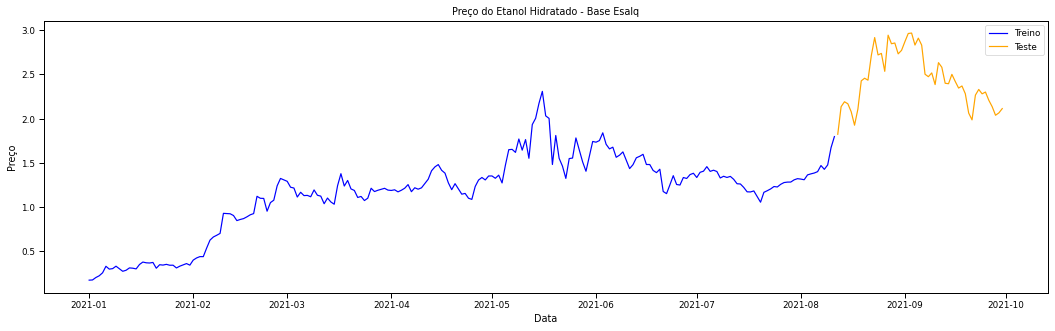

In [58]:
plt.figure(figsize=(18,5))
plt.title('Preço do Etanol Hidratado - Base Esalq')
plt.plot(treino['Adj Close'], color='b')
plt.plot(teste['Adj Close'], color='orange')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()

In [59]:
#criando uma função para plotar o gráfico e mostrar o resultado do teste:
def checar_estacionariedade(y, lags_plots=48, figsize=(22,8)):
    "Use Series como parâmetro"
    
    # Criando plots do DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize, color='teal')
    ax1.set_title('Série de Preços')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2, color='teal');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols', color='teal');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4, color='teal')
    ax4.set_title('Distribuição dos Preços')

    plt.tight_layout()
    
    print('Resultados do teste de Dickey-Fuller:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Teste Statistico','Valor-P','Lags Usados','Números de Observações'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Valores Críticos (%s)"%key] = value.round(4)
        
    print(adftest)

Resultados do teste de Dickey-Fuller:
Teste Statistico           -1.9317
Valor-P                     0.3173
Lags Usados                12.0000
Números de Observações    210.0000
Valores Críticos (1%)      -3.4619
Valores Críticos (5%)      -2.8754
Valores Críticos (10%)     -2.5742
dtype: float64


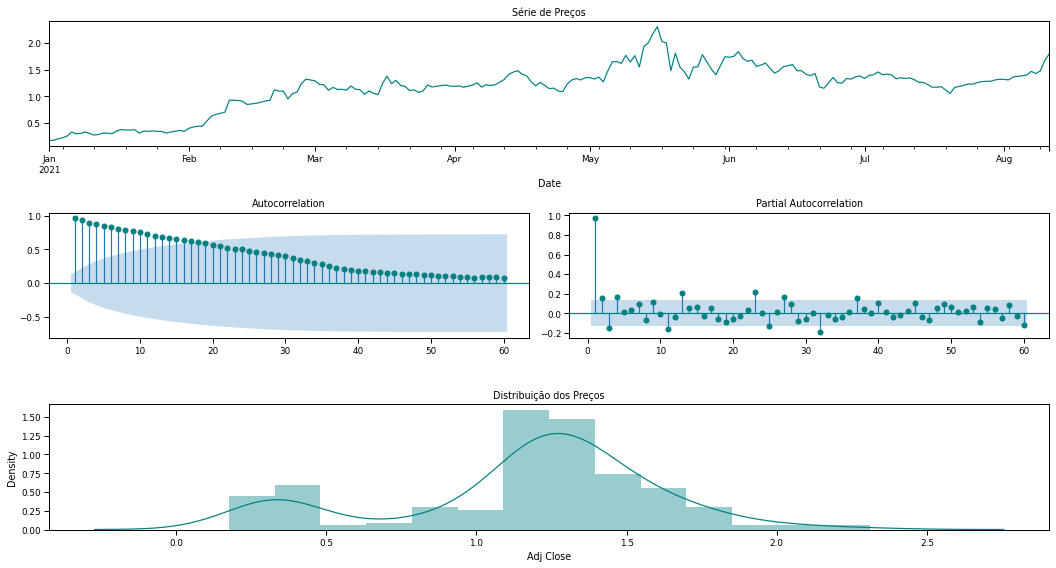

In [60]:
checar_estacionariedade(treino['Adj Close'], lags_plots=60)

Resultados do teste de Dickey-Fuller:
Teste Statistico           -6.6943
Valor-P                     0.0000
Lags Usados                10.0000
Números de Observações    210.0000
Valores Críticos (1%)      -3.4619
Valores Críticos (5%)      -2.8754
Valores Críticos (10%)     -2.5742
dtype: float64


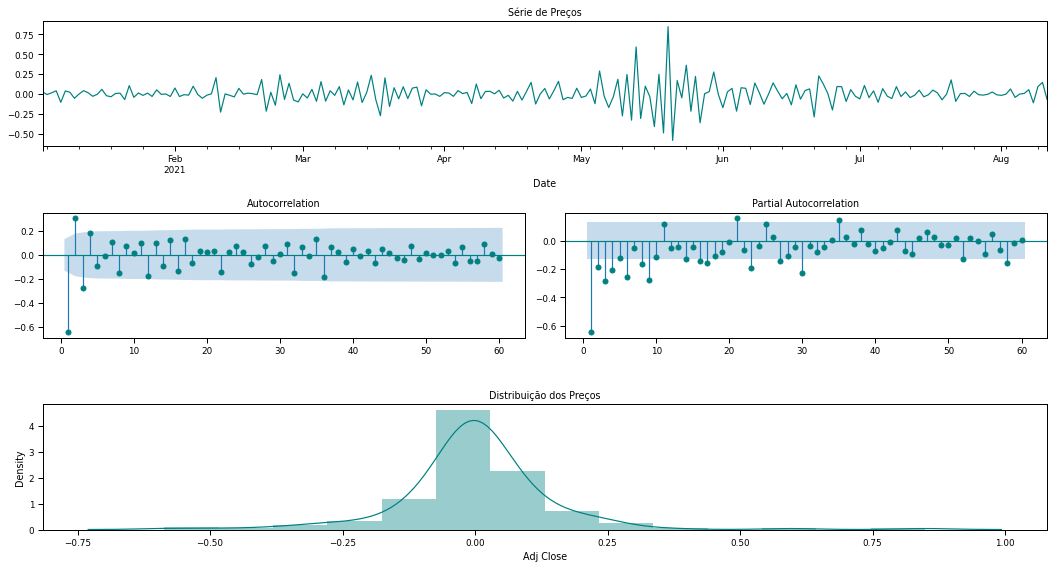

In [61]:
checar_estacionariedade(treino['Adj Close'].diff().diff().dropna(), lags_plots=60)

# Criando o Modelo

Inicialmente o modelo será criado com base nos dados de treino, assim, os coeficientes para os 3 lags auto correlacionados serão gerados e servirão para testar a extrapolação de 5 dias consecutivos na base de testes.

Existem diversas maneiras de se fazer extrapolações para o futuro, as principais são:

 * Criar um modelo para cada dia a ser previsto e agregar tudo posteriormente,
 * Recursivo, prevendo o primeiro dia e usar essa previsão como base para prever o próximo dia.
 
Usaremos o último modelo neste exemplo, neste caso iremos prever os próximos 5 dias, comparar com dados reais, adicionar estes últimos novamente na base para fazer uma nova extrapolação, posteriormente iremos calcular o erro do modelo e analisar fatos relevantes da previsão.

In [62]:
# Treinando o modelo
modelo = ARIMA(treino, order=(3,1,0)).fit()
pred_treino = modelo.predict()

In [63]:
# Base de previsão com diferenciação
pred_treino[:5]

2021-01-02    0.007164
2021-01-03    0.007963
2021-01-04    0.003691
2021-01-05    0.009054
2021-01-06    0.002308
Freq: D, dtype: float64

In [64]:
# Voltando para a base de preços em R$/m3
pred_treino[0] += treino.iloc[0,0]
pred_treino = np.cumsum(pred_treino)
pred_treino.head()

2021-01-02    0.182514
2021-01-03    0.190477
2021-01-04    0.194167
2021-01-05    0.203222
2021-01-06    0.205530
Freq: D, dtype: float64

In [65]:
treino['Pred Close'] = pred_treino
treino.dropna(inplace=True)
treino.head()

,Adj Close,Pred Close
Date,,
2021-01-02,0.177423,0.182514
2021-01-03,0.204995,0.190477
2021-01-04,0.224762,0.194167
2021-01-05,0.258314,0.203222
2021-01-06,0.331898,0.205530


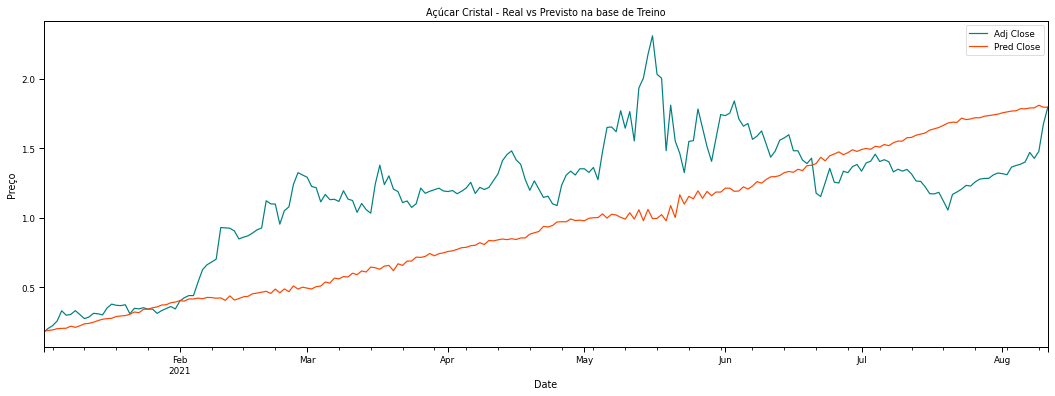

In [66]:
# Plotando o gráfico
treino.plot(figsize=(18,6), 
            title='Açúcar Cristal - Real vs Previsto na base de Treino',
           color=['Teal','orangered'])
plt.ylabel('Preço')
plt.show()

Na base de treino o modelo consegue capturar os principais momentos do mercado. Somente quando há maiores variações que a previsão não consegue capturar o movimento, agora vamos analisar o erro do modelo:

In [67]:
#Medindo o erro do treino pela métrica Root Mean Squared Error
from sklearn.metrics import mean_squared_error
erro = sqrt(mean_squared_error(treino['Adj Close'], treino['Pred Close']))
print(f'O RMSE foi de R$ {round(erro,4)}/sc')

O RMSE foi de R$ 0.4393/sc


# Obtendo os Coeficientes

Após treinar o modelo, podemos obter os coeficientes de multiplicação dos lags junto com o valor da constante, esses valores servirão como base para extrapolarmos as previsões para os próximos 5 dias.

In [68]:
# Pegando os coeficientes de múltiplicação dos lags para usar na base de testes:
const, l1, l2, l3 = modelo.params

print(f'Valor da constante {round(const,4)}')
print(f'Coeficientes do Lag 1: {round(l1,4)}, Lag 2: {round(l2,4)} e Lag 3: {round(l3,4)}')

Valor da constante 0.0072
Coeficientes do Lag 1: -0.1109, Lag 2: 0.1192 e Lag 3: -0.1681


O próximo passo é criar uma função para fazer as previsões, usarei todas as bases com diferenciação, criarei a previsão para 5 períodos adiante e atualizarei os dados reais com mais 5 dias e assim sucessivamente até finalizarem os dados de teste.

In [69]:
def prever_n_per(treino, teste, passos):
    
    # Adicionando a série com diferenciação para projetar previsões
    diff_treino = treino.diff().dropna().values
    hist = [x for x in diff_treino]

    diff_teste = teste.diff().dropna().values
    diff_teste = [x for x in diff_teste]

    # Adicionando primeira diferenciação no teste que ficou entre o treino e teste
    prim_diff = teste[0] - treino[-1]
    diff_teste.insert(0, prim_diff)
    
    prev = []

    for i in range(0,len(teste),passos):
        for j in range(passos):
    
            yhat = const + (l1 * hist[-1]) + (l2 * hist[-2]) + (l3 * hist[-3])
            prev.append(yhat)
            # usando a previsão atual como base para novas previsões
            hist.append(yhat)
        obs = diff_teste[i:i+passos]
        hist = list(np.append(hist,obs))
    return prev

In [71]:
# Testando a função
steps = 5
prev = prever_n_per(treino['Adj Close'], teste['Adj Close'], passos=steps)
print('Previsões antes de reverter os preços: ')
print(prev[:5])

Previsões antes de reverter os preços: 
[0.008111369148748474, -0.011543186408524878, -0.011679752035114734, 0.005719535796264533, 0.007076988429862802]


Do mesmo jeito que criamos a função para prever os preços com 5 dias de extrapolação, iremos criar a função abaixo para transformar os preços previstos para a base comparável com os preços reais da base de teste.

In [72]:
def inverter_diff(treino, teste, previsão, passos):
    '''
    Usando o último dia da base de treino, após isso, usa o último valor previsto como base sucessivamente.
    
    A cada passo, volta a usar o primeiro valor da base de teste que se tornou real.
    '''
    treino = [x for x in treino]
    teste = [x for x in teste]
    prev_inv = []
    
    for i in range(0,len(teste), passos): 
        inverter = previsão[i] + treino[-1]
        prev_inv.append(inverter)
        
        for j in range(passos-1):
            inverter += previsão[i+j+1]
            prev_inv.append(inverter)
        treino = np.append(treino, teste[i:i+passos])
    return prev_inv

In [73]:
# Adicionando a previsão na base de testes para comparar posteriormente
teste['Previsão 5D'] = inverter_diff(treino['Adj Close'],
                                     teste['Adj Close'],
                                     prev, passos=steps)

# Plotando o Comparativo

Para finalizar, a função abaixo irá separar cada previsão pelos períodos de 5 dias e comparar com a base de testes:

In [74]:
def plotar_comparativo(orig, prev, passos, titulo='', figsize=(18,6)):
    plt.figure(figsize=figsize)
    
    orig = np.array(orig)
    prev = np.array(prev)
    plt.plot(orig, label='Real', color='teal')
    
    for i in range(0,len(orig), passos):
        eixo_x = [x for x in range(i,i+passos)]
        plt.plot(eixo_x, prev[i:i+passos], color='orangered')
    
    plt.title(titulo)
    plt.ylabel('Preços')
    plt.show()

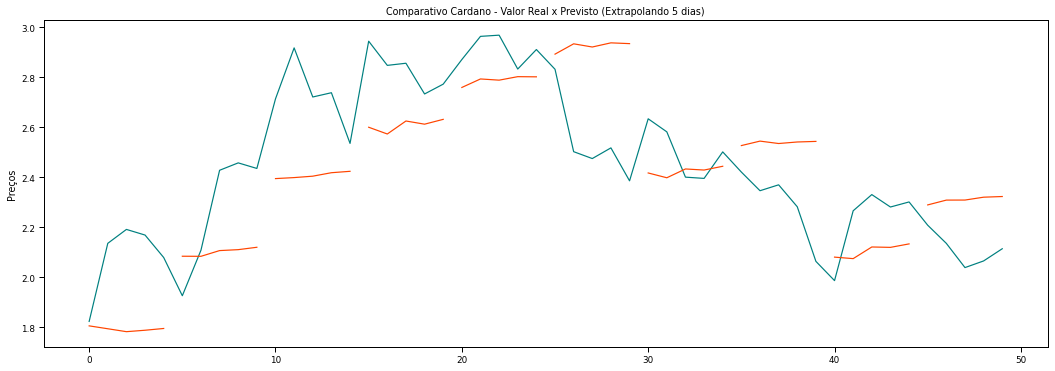

In [75]:
plotar_comparativo(teste['Adj Close'], teste['Previsão 5D'], passos=steps, 
                   titulo='Comparativo Cardano - Valor Real x Previsto (Extrapolando 5 dias)')

In [76]:
erro_teste = sqrt(mean_squared_error(teste['Adj Close'], teste['Previsão 5D']))
print(f'O RMSE da base de testes foi de R$ {round(erro_teste,4)}/sc')

O RMSE da base de testes foi de R$ 0.2645/sc


Avaliando o gráfico acima, nota-se que a principal característica desse tipo de previsão é que ele segue a tendência mais recente que está sendo negociada, porém ainda há espaço para melhoras, o modelo não é capaz de prever possíveis mudanças de tendências.

No próximo vai ser analisar o erro (previsto - real), pois neste tipo de análise pode-se obter informações para melhorar o modelo.

# Analisando o Erro

Para analisar o erro criarei uma função semelhante às anteriores, irão ser analisados os valores médios de cada um dos 5 passos, normalmente a tendência é que o erro, neste caso o RMSE, aumente de acordo com os períodos que vão se expandindo devido às incertezas, veremos abaixo:

In [77]:
def erro_n_passos(orig, prev, passos, plot=True):
    # Calculando o RMSE de cada linha
    erro = ((np.array(orig) - np.array(prev))**2)**(1/2)
    
    # Mudando o formato para ficar: (erros/exemplos, passos)
    erro = erro.reshape(int(len(erro)/passos), passos)
    
    # Fazendo a média do erro para cada passo
    media = erro.mean(axis=0)
    
    # Plotando o gráfico de erro
    if plot:
        indice = np.arange(0,passos)
        plt.figure(figsize=(12,4))
        plt.plot(media, 'o-', color='teal', markersize=8)
        plt.title('Erro Médio para Cada Passo', fontsize=15)
        plt.xlabel('Passos', fontsize=15)
        plt.ylabel('Erro', fontsize=15)
        for x,y in zip(indice, media):
            label = "{:.4f}".format(y)
            plt.annotate(label, (x, y), xytext=(x-0.1, y+.075), fontsize=12)
        plt.xticks(np.arange(passos), [x for x in range(1,passos+1)])
        plt.yticks([x for x in np.linspace(min(media)-0.2, max(media)+0.2, 10)])
        plt.grid(axis='y')
        plt.show()
    print(f'O RMSE para cada passo ficou assim: \n{media}')

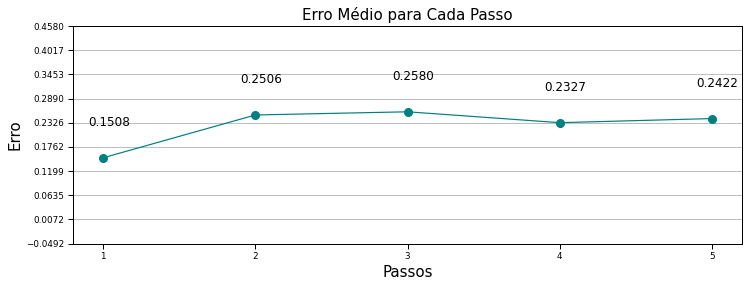

O RMSE para cada passo ficou assim: 
[0.15080676 0.25061346 0.25803177 0.2326746  0.24222555]


In [78]:
erro_passo = erro_n_passos(teste['Adj Close'], teste['Previsão 5D'], steps)
erro_passo

%matplotlib notebook

passos = 5
eixo_x_prev = []
eixo_x_real = [x for x in range(len(teste))]
prev = []
pred = np.array([x for x in teste['Previsão 5D']])
base = [x for x in teste['ohlc_preco']]

for i in range(0,len(teste), passos):
    eixo_x_prev.append([x for x in range(i,i+passos)])
    prev.append([x for x in pred[i:i+passos]])

# Criando a base dos gráficos
fig = plt.figure(figsize=(10.5,5))
plt.axis([0, len(base), min(base)-2.5,max(base)+2.5])

def animate(i):
    
    plt.plot(eixo_x_prev[i], prev[i], c='orangered', lw=1)
    plt.plot(eixo_x_real[:i*passos], base[:i*passos], c='teal', lw=0.50)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Preços', fontsize=15)
plt.title('Comparativo Preço Açúcar Cristal - Real x Previsto', fontsize=15)
plt.axis([0, len(base), min(base)-1.5 ,max(base)+1.5])
    

ani = FuncAnimation(fig, animate, frames=50, interval=250)
#ani.save('comparativo.htm')
plt.show()

In [79]:
teste.head(2)

,Adj Close,Previsão 5D
Date,,
2021-08-12,1.823878,1.806149
2021-08-13,2.136079,1.794606


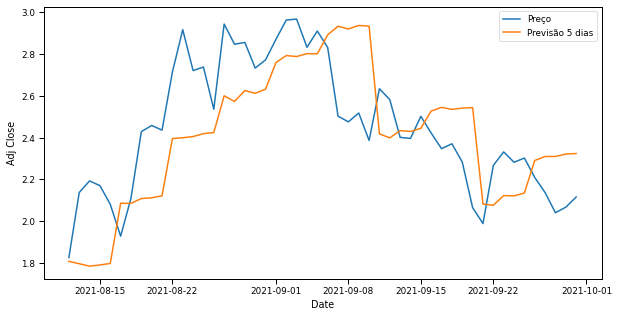

In [80]:
plt.figure(figsize=(10,5))

sns.lineplot(data=teste['Adj Close'],linewidth = 1.5 , label = 'Preço')
sns.lineplot(data=teste['Previsão 5D'],linewidth = 1.5 , label = 'Previsão 5 dias')


plt.show()

In [82]:
teste['Media_2'] = teste["Adj Close"].rolling(2, min_periods=2).mean()
teste['Media_5'] = teste["Previsão 5D"].rolling(4, min_periods=4).mean()

In [84]:
#Criação da coluna SINAL com o cruzamento da Média de 14 dias com a Média de 30 dias

teste['sinal'] = np.where(teste['Media_2']>teste['Media_5'],1,0)
teste.head(4)

,Adj Close,Previsão 5D,Media_2,Media_5,sinal
Date,,,,,
2021-08-12,1.823878,1.806149,NaN,NaN,0
2021-08-13,2.136079,1.794606,1.979979,NaN,0
2021-08-14,2.191687,1.782926,2.163883,NaN,0
2021-08-15,2.169153,1.788646,2.180420,1.793082,1


In [85]:
teste['pos'] = teste['sinal'].diff()
teste.head(3)

,Adj Close,Previsão 5D,Media_2,Media_5,sinal,pos
Date,,,,,,
2021-08-12,1.823878,1.806149,NaN,NaN,0,NaN
2021-08-13,2.136079,1.794606,1.979979,NaN,0,0.0
2021-08-14,2.191687,1.782926,2.163883,NaN,0,0.0


In [42]:
data = data.loc['2021-08-01':'2021-09-30',:]

In [93]:
data1 = yf.Ticker("ADA-USD")
data1 = data1.history(start="2019-01-01", end="2021-09-30", interval="1d", prepost=bool,
                      actions=False, threads=True, auto_adjust=True, back_adjust=True, rounding=True)
data1.head(2)

data1 = data1.loc['2021-08-01':'2021-12-31',:]


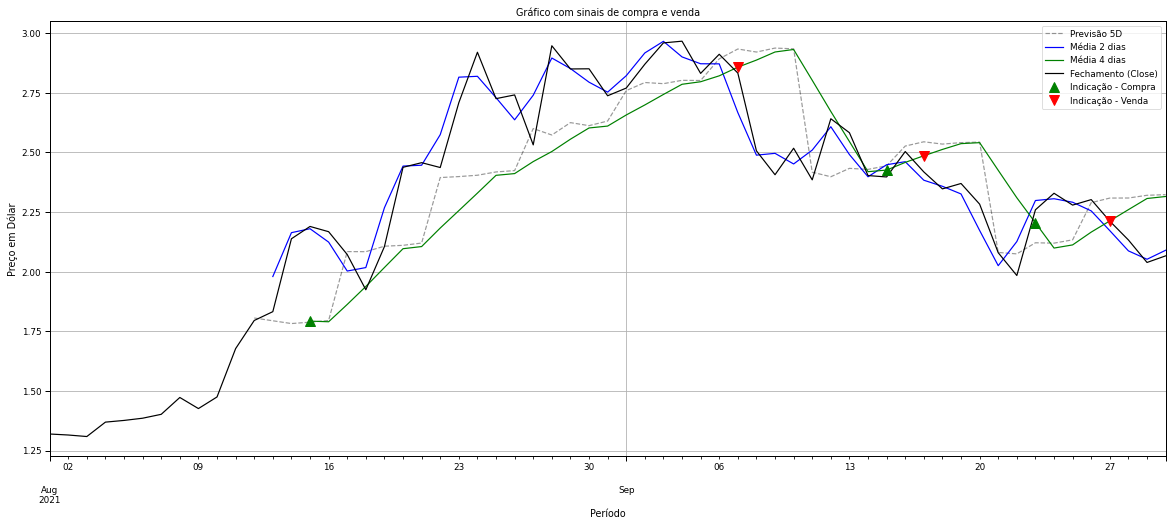

In [95]:
plt.figure(figsize = (20,8))
teste['Previsão 5D'].plot(color = 'k',linestyle='--',alpha=0.4, label = 'Previsão 5D')
#data['ohlc_preco'].plot(color = 'r', label = 'Fechamento (Close)')
teste['Media_2'].plot(color = 'b', label = 'Média 2 dias')
teste['Media_5'].plot(color = 'g', label = 'Média 4 dias')
data1['Open'].plot(color = 'k', label = 'Fechamento (Close)')





plt.plot(teste[teste['pos']== 1].index,
         teste['Media_5'][teste['pos']== 1],
         '^', markersize = 10, color = 'g', label = 'Indicação - Compra')

plt.plot(teste[teste['pos']== -1].index,
         teste['Media_5'][teste['pos']== -1],
         'v',markersize = 10, color = 'r', label = 'Indicação - Venda')

plt.ylabel('Preço em Dólar')
plt.xlabel("Período")
plt.title('Gráfico com sinais de compra e venda')
plt.legend()
plt.grid()
plt.show()


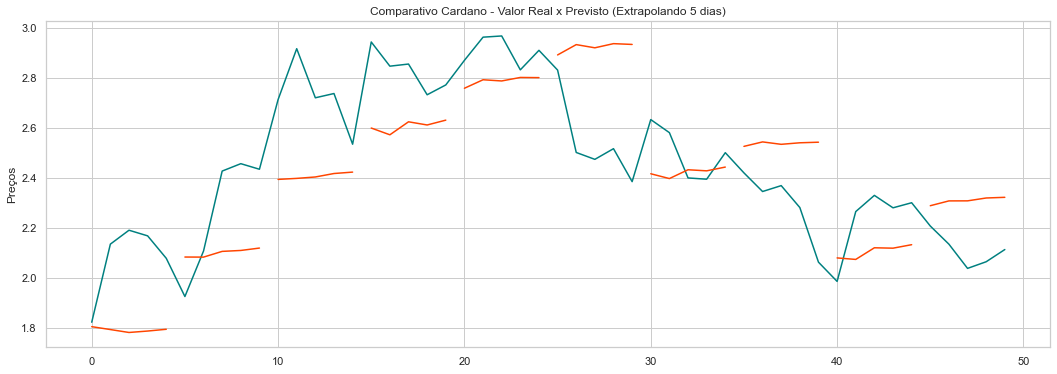

In [120]:
plotar_comparativo(teste['Adj Close'], teste['Previsão 5D'], passos=steps, 
                   titulo='Comparativo Cardano - Valor Real x Previsto (Extrapolando 5 dias)')



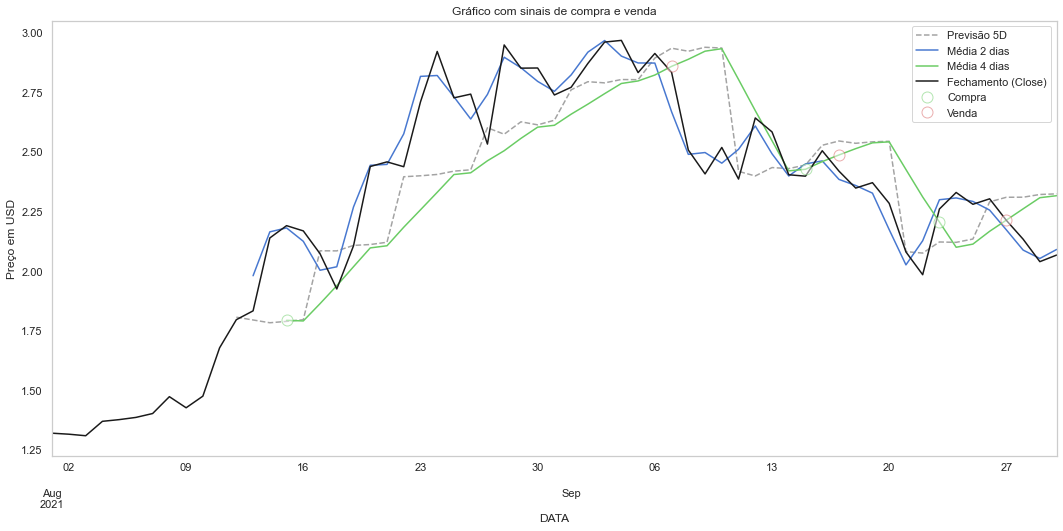

In [121]:
plt.figure(figsize = (18,8))
teste['Previsão 5D'].plot(color = 'k',linestyle='--',alpha=0.4, label = 'Previsão 5D')
#data['ohlc_preco'].plot(color = 'r', label = 'Fechamento (Close)')
teste['Media_2'].plot(color = 'b', label = 'Média 2 dias')
teste['Media_5'].plot(color = 'g', label = 'Média 4 dias')
data1['Open'].plot(color = 'k', label = 'Fechamento (Close)')



plt.plot(teste[teste['pos']== 1].index,
         teste['Media_5'][teste['pos']== 1],
         'o', markerfacecolor="w", markersize = 11, color = 'g', alpha=0.5, label = 'Compra')

plt.plot(teste[teste['pos']== -1].index,
         teste['Media_5'][teste['pos']== -1],
         'o', markerfacecolor="w", markersize = 11, color='r', alpha=0.5, label = 'Venda')

plt.ylabel('Preço em USD')
plt.xlabel("DATA")
plt.title('Gráfico com sinais de compra e venda')
plt.legend()
plt.grid()
plt.show()
